# Right, but Why?
## Interpreting Linear Models - watchout the pitfalls!
Written by Dr. Hanan Shteingart
All Right Reserved

# Why?
* You will learn how to avoid pitfalls when interprating linear models.

# Imports

In [1]:
%pylab inline
import sklearn
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_breast_cancer
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load Data and Split to Train Test

In [2]:
data = load_breast_cancer()
x = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42)

# Model Fit

In [3]:
model = LogisticRegression()
model.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# Performance

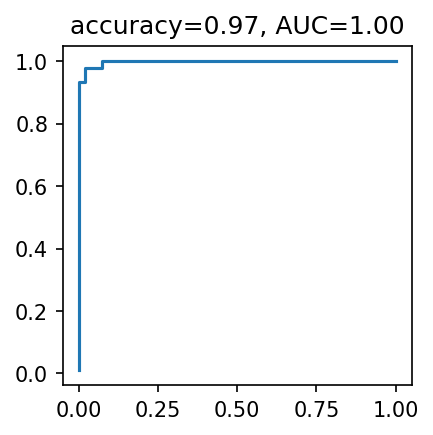

In [4]:
y_score = model.predict_proba(x_test)[:,1]
fp,tp, th=roc_curve(y_true=y_test, y_score=y_score)
plt.figure(figsize=(3,3),dpi=150)
plt.plot(fp,tp)
accuracy = model.score(x_test, y_test)
auc = roc_auc_score(y_test, y_score)
plt.title('accuracy={:.2f}, AUC={:.2f}'.format(accuracy, auc));

# Exercise
Find the most important features

# Importance by Coeffient Magnitude

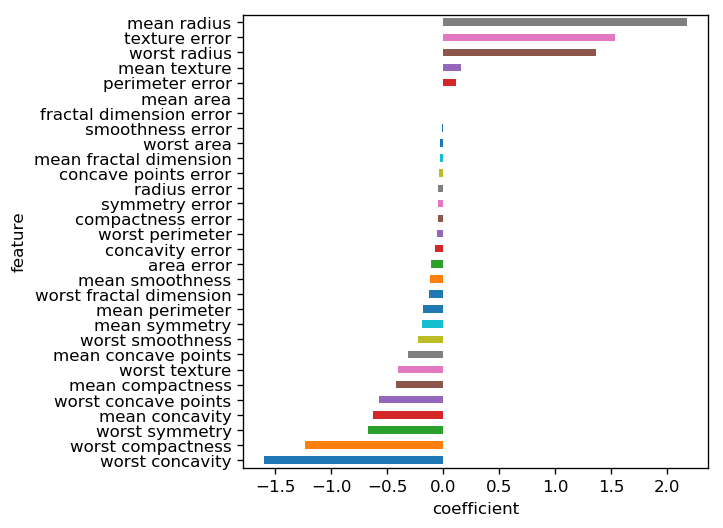

In [5]:
def get_coefs(model):
    coefs = pd.Series(model.coef_.ravel(), index=data.feature_names)
    return coefs
coefs = get_coefs(model)
plt.figure(figsize=(5,5), dpi=120)
coefs.sort_values().plot.barh()
plt.xlabel('coefficient')
plt.ylabel('feature');

## WRONG! 
The coefficients are very sensitive to scale
![wrong](https://media1.giphy.com/media/hPPx8yk3Bmqys/200w.webp)

## Scaling a Feature changes its Coefficient 

coefficient of "worst concavity" used to be -1.60, now its -0.01


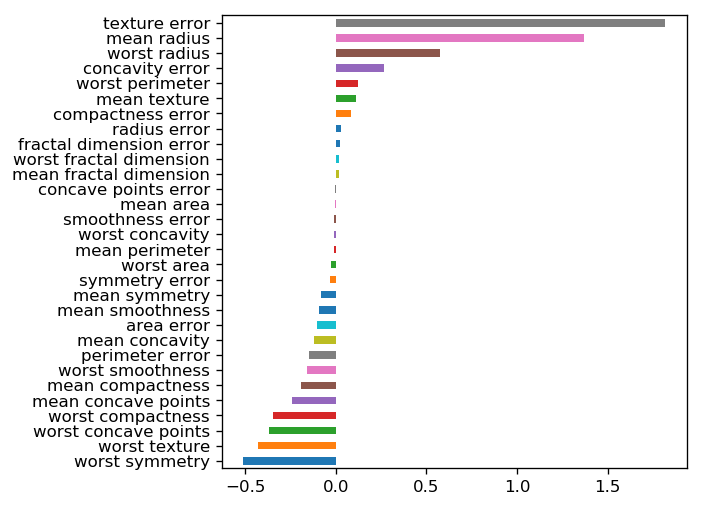

In [6]:
col = 'worst concavity'
x_train_scaled = x_train.copy()
# scale the units of the feature with the largest weight by 1000 (e.g. milimeters instead of meters )
x_train_scaled[col] = x_train_scaled[col]*1000
model.fit(x_train_scaled, y_train)
coefs_scaled = get_coefs(model)
plt.figure(figsize=(5,5), dpi=120)
coefs_scaled.sort_values().plot.barh()
print('coefficient of "{}" used to be {:.2f}, now it''s {:.2f}'.format(col, coefs[col], coefs_scaled[col]))

## Normalize Features and or Compute Z-scores
How can we be insensitive to scaling of features?
1. normalize feature, e.g. by using StandardScaler
2. compute Z-scores by dividing coefficient by the standard deviation of a shuffle 
3. use analytic formula for logistic regression p-values. See [P values for sklearn logistic regression](https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d)

When the features are correlated **neither will work**!

# Normalization pipeline

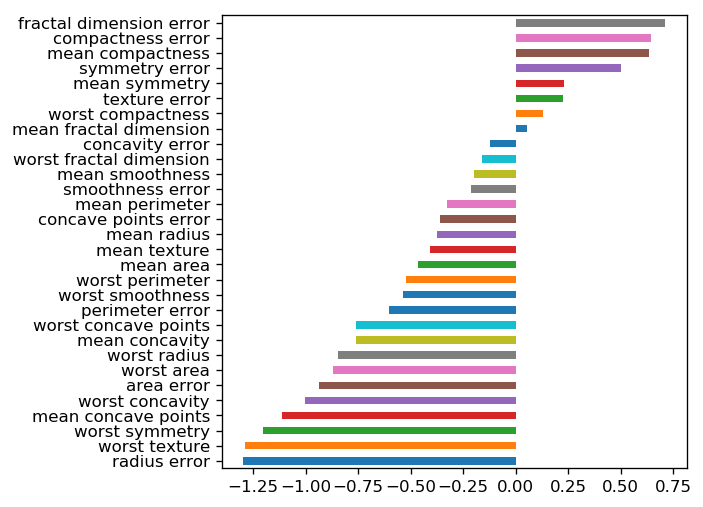

In [7]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression())
pipeline.fit(x_train, y_train)
pipeline_coefs = get_coefs(pipeline.steps[1][1])
plt.figure(figsize=(5,5), dpi=120)
pipeline_coefs.sort_values().plot.barh()

# Coefficient Sign is Misleading

(569, 31)


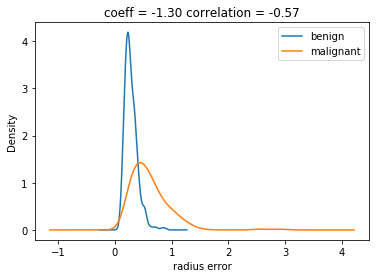

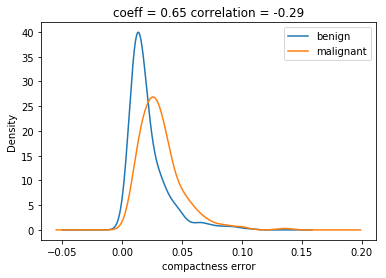

In [16]:
df = x.copy()
df['label'] = data.target_names[y]
print(df.shape)
for col in ['radius error','compactness error']:
    plt.figure()
    df.groupby('label')[col].plot(kind='kde', legend=True);
    rho = np.corrcoef(df[col], y)[0,1]
    plt.title('coeff = {:.2f} correlation = {:.2f}'.format(pipeline_coefs[col], rho))
    plt.xlabel(col)

# Measuring Importance by Shuffeling

malignant
0.9975031210986267


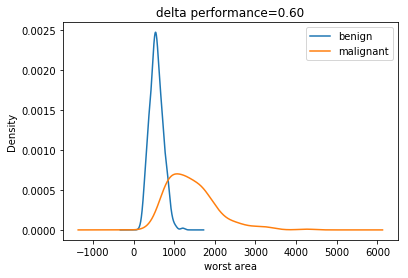

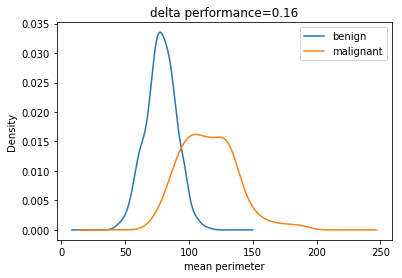

In [9]:
model.fit(x_train,y_train)
print(data.target_names[0])
perf0 = roc_auc_score(data.target_names[y_test]==data.target_names[0],
                      model.predict_proba(x_test)[:,0])
print(perf0)
perf = {}
for col in x_train.columns:
    label = data.target_names[y_test]==data.target_names[0]
    v = copy(x_test[col].values)
    np.random.shuffle(v)
    x_test_shuffle = x_test.copy()
    x_test_shuffle[col] = v
    score = model.predict_proba(x_test_shuffle)[:,0]
    perf[col] = roc_auc_score(label,score) 
perf = pd.Series(perf)
dperf = perf0 - perf
dperf = dperf.sort_values(ascending=False)
for col in dperf.head(2).index:
    plt.figure()
    df.groupby('label')[col].plot(kind='kde', legend=True);
    rho = np.corrcoef(df[col], y)[0,1]
    plt.title('delta performance={:.2f}'.format(dperf[col]))
    plt.xlabel(col)

# Considering the single sample
So far we have discussed just feature importance in general. 
** What about the single-sample feature importance? **


benign       2.052944e-09
malignant    1.000000e+00
dtype: float64


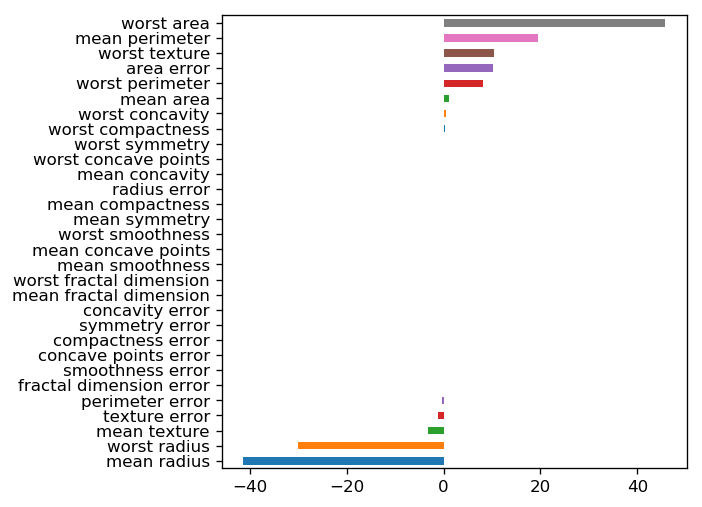

In [10]:
idx = 1
model.fit(x_train, data.target_names[y_train])
instance = x_test.iloc[idx]
yhat = model.predict_proba(instance.to_frame().T)
print(pd.Series(yhat.ravel(), index=model.classes_))
coef = pd.Series(model.coef_.ravel(), index=data.feature_names)
wx = instance * coef
wx=wx.sort_values()
plt.figure(figsize=(5,5), dpi=120)
wx.plot.barh()

# Again, $w_i x_i$ product is misleading

mean radius
worst area


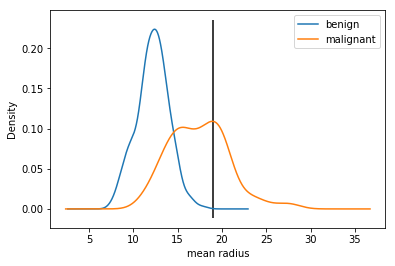

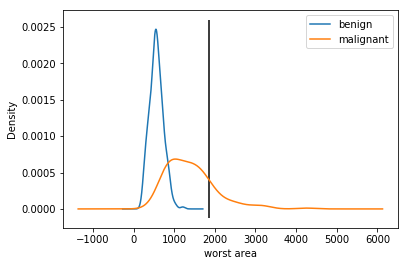

In [17]:
df = x_train.copy()
df['label'] = data.target_names[y_train]
for col in [wx.head(1).index[0], wx.tail(1).index[0]]:
    print(col)
    plt.figure()
    df.groupby('label')[col].plot(kind='kde', legend=True);
    plt.vlines(instance[col],ymin=plt.ylim()[0], ymax=plt.ylim()[1])
    plt.xlabel(col)

# Local interpretation via Shuffeling

In [33]:
model.fit(x_train, data.target_names[y_train])
instance = x_test.iloc[idx]
yhat = model.predict_log_proba(instance.to_frame().T)
print(yhat)
p = {}
many_instances = pd.DataFrame(np.tile(instance.values.reshape(-1,1), 
                                      reps=x_test.shape[0]).T, 
                              columns=x_test.columns)
for col in x_train.columns:
    v = many_instances.copy()
    v[col] = x_test[col].values.copy()
    p[col] = model.predict_log_proba(v)[:,1].mean()
p = pd.Series(p).sort_values()
dp = yhat[:,1] - p
dp_sorted = dp.sort_values(ascending=False)
dp_sorted

[[-2.00039912e+01 -2.05294360e-09]]


/Users/hanans/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1356: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


worst area                 8.088105e+00
mean radius                1.360408e-05
mean perimeter             1.170811e-05
area error                 4.927115e-06
worst radius               1.675757e-07
worst perimeter            8.536924e-08
worst texture              1.921937e-08
texture error              4.991432e-09
mean area                  1.489016e-09
worst concave points       7.539788e-11
worst concavity            6.807885e-11
radius error               5.398095e-11
mean concavity             2.328767e-11
mean concave points        1.903460e-11
concave points error       1.667198e-13
fractal dimension error   -8.774644e-15
smoothness error          -7.542995e-14
mean fractal dimension    -5.816062e-13
compactness error         -6.658574e-13
symmetry error            -6.754907e-13
concavity error           -1.161562e-12
mean smoothness           -2.294016e-12
worst fractal dimension   -4.957154e-12
mean compactness          -5.424444e-12
worst smoothness          -8.220627e-12


Text(0.5,0.98,'contradictors')

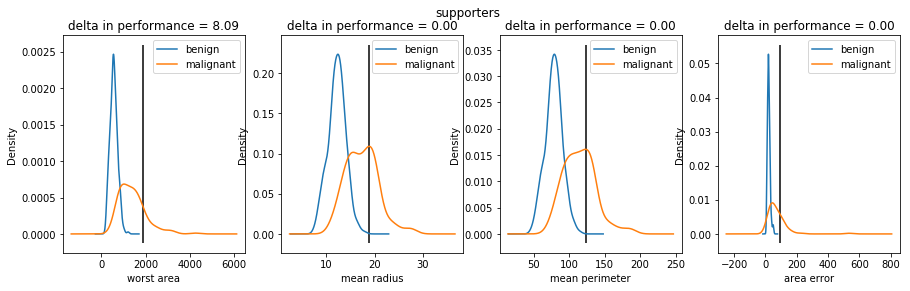

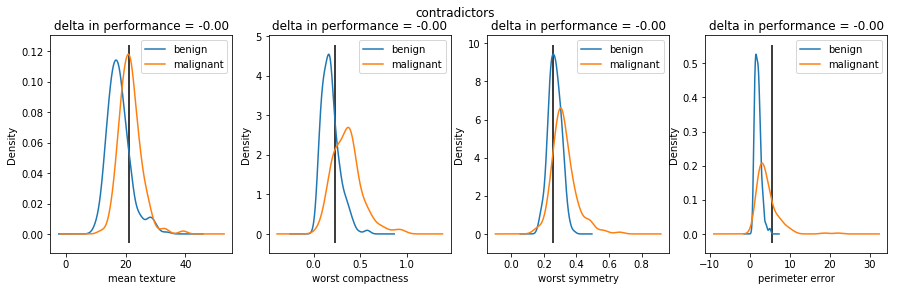

In [39]:
plt.figure(figsize=(15,4))
for i, col in enumerate(dp_sorted.head(4).index):
    plt.subplot(1,4, i+1)
    df.groupby('label')[col].plot(kind='kde', legend=True);
    plt.vlines(instance[col],ymin=plt.ylim()[0], ymax=plt.ylim()[1])
    plt.xlabel(col)
    plt.title('delta in performance = {:.2f}'.format(dp_sorted[col]))
plt.suptitle('supporters')
plt.figure(figsize=(15,4))
for i, col in enumerate(dp_sorted.tail(4).index):
    plt.subplot(1,4, i+1)
    df.groupby('label')[col].plot(kind='kde', legend=True);
    plt.vlines(instance[col],ymin=plt.ylim()[0], ymax=plt.ylim()[1])
    plt.xlabel(col)
    plt.title('delta in performance = {:.2f}'.format(dp_sorted[col]))
plt.suptitle('contradictors')

# Summary
![](linear_interp.png)